## Preparation

In [35]:
# importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
# carregando os dados
df = pd.read_csv('/datasets/taxi.csv',parse_dates=[0], index_col=[0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# convertendo datetime de object para datetime
# df["datetime"] = pd.to_datetime(df["datetime"])

In [6]:
# verificando se df está ordenado cronologicamente
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


## Analysis

<AxesSubplot:xlabel='datetime'>

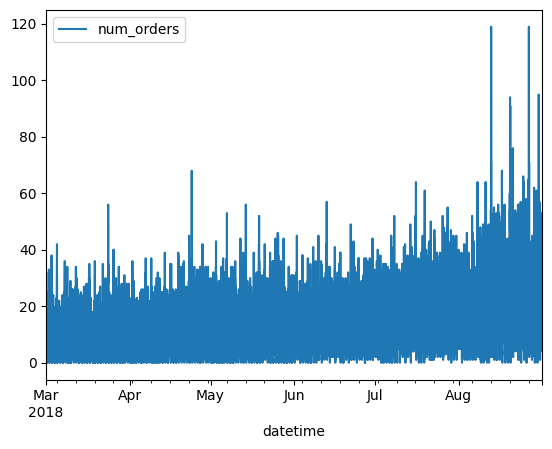

In [7]:
df.plot()

<AxesSubplot:xlabel='datetime'>

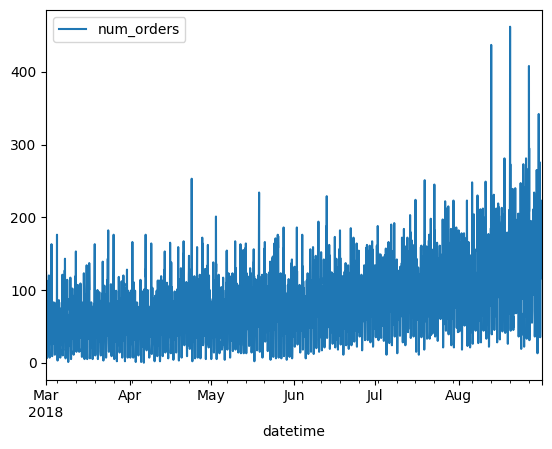

In [8]:
# agrupando por hora pois queremos prever a próxima hora
df = df.resample('1H').sum()
df.plot()

Text(0.5, 1.0, 'Resíduos')

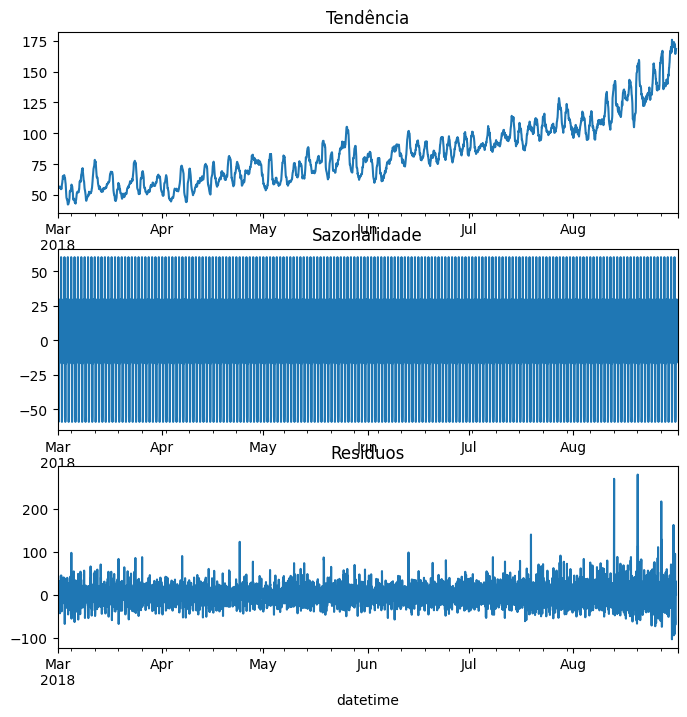

In [9]:
# analisando tendencia, sazonalidade e resíduos
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')

Conclusion: There is an upward trend over time, increasing from 50 to 175 during the period. Seasonality is constant and cyclical, and the residuals are relatively stable.


In [10]:
# criando as características

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data["num_orders"].shift().rolling(rolling_mean_size).mean()

make_features(df, 4, 4)
df.head(10)

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,19.00


## Model Training

In [13]:
# criando conjunto de treinamento e de teste
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

# selecionando colunas para os conjuntos
features_train = train.drop(['num_orders'],axis=1)
target_train = train["num_orders"]

features_test = test.drop(['num_orders'],axis=1)
target_test = test["num_orders"]

# criando a regressão
lr = LinearRegression()
lr.fit(features_train,target_train)

# previsões
predict_train = lr.predict(features_train)

# calculando mse
mse_train = np.sqrt(mean_squared_error(target_train,predict_train))

print("REQM treinamento:", mse_train)

REQM treinamento: 30.500374252442192


## Testing Predictions

In [14]:
# testando as previsões

# previsões
predict_test = lr.predict(features_test)

# previsões
mse_test = np.sqrt(mean_squared_error(target_test,predict_test))

print("REQM teste:", mse_test)

REQM teste: 52.57450685373692


In [21]:
# otimizando a regressão

param_grid = {
    'fit_intercept': [True, False],
    'copy_X':[True,False],
    'normalize':[True,False],
    'positive':[True,False],

}

model = LinearRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(features_train, target_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Avaliando o melhor modelo com conjunto de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(features_test)
mse_opt = np.sqrt(mean_squared_error(y_pred,target_test))

print("Test Score:", best_model.score(features_test, target_test))
print("REQM otimizado:", mse_opt)

Best Parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False, 'positive': False}
Best Score: -951.5697260977255
Test Score: 0.19368932080760448
REQM otimizado: 52.57450685373692


In [34]:
# testando modelo de árvore de decisão

tree_reg = DecisionTreeRegressor(max_depth=15,min_samples_leaf=10, min_samples_split=2)
tree_reg.fit(features_train, target_train)
pred_tree = tree_reg.predict(features_test)
rmse_tree = np.sqrt(mean_squared_error(target_test, pred_tree))

print("Decision Tree Regression:")
print(f"REQM: {rmse_tree:.2f}")

Decision Tree Regression:
REQM: 48.08


In [33]:
# testando foresta aleatória

rf_reg = RandomForestRegressor()
rf_param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [1, 5, 10],
    'min_samples_split': [2, 5, 7]
}
rf_grid_search = GridSearchCV(rf_reg, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(features_train, target_train)

# previsões
pred_rf = rf_grid_search.best_estimator_.predict(features_test)

# calculando mean squared error
rmse_rf = np.sqrt(mean_squared_error(target_test, pred_rf))

print("Random Forest Regressor:")
print("Best hyperparameters:", rf_grid_search.best_params_)
print("Best score:", rf_grid_search.best_score_)
print(f"RMSE: {rmse_rf:.2f}")

Random Forest Regressor:
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best score: -650.9937035245223
RMSE: 48.52


In [36]:
# testando lgb

lgb_reg = lgb.LGBMRegressor(learning_rate=0.1, max_depth=7, n_estimators=50, num_leaves=20)
lgb_reg.fit(features_train, target_train)

# previsões
pred_lgb = lgb_reg.predict(features_test)

# calculando mean squared error
rmse_lgb = np.sqrt(mean_squared_error(target_test, pred_lgb))

print("LightGBM:")
print(f'RMSE: {rmse_lgb:.2f}')

LightGBM:
RMSE: 45.32


In [46]:
# testando gradient boosting

gb_reg = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, max_features='sqrt', n_estimators=50, subsample=0.8)
gb_reg.fit(features_train, target_train)

# previsões
pred_gb = gb_reg.predict(features_test)

# calculando mean squared error
rmse_gb = np.sqrt(mean_squared_error(target_test, pred_gb))

print("GradientBoostingRegressor:")
print(f'RMSE: {rmse_gb:.2f}')

GradientBoostingRegressor:
RMSE: 47.75


In [47]:
# testando catboost

cat_reg = CatBoostRegressor(depth=7, iterations=50, l2_leaf_reg=0.1, learning_rate=0.5)
cat_reg.fit(features_train, target_train)

# previsões
pred_cat = cat_reg.predict(features_test)

# calculando mean squared error
rmse_cat = np.sqrt(mean_squared_error(target_test, pred_cat))

print("CatBoost Regressor:")
print(f'RMSE: {rmse_cat:.2f}')

0:	learn: 31.1243043	total: 50.7ms	remaining: 2.48s
1:	learn: 27.4573942	total: 54.6ms	remaining: 1.31s
2:	learn: 25.2151471	total: 58.8ms	remaining: 921ms
3:	learn: 23.9873531	total: 62.7ms	remaining: 721ms
4:	learn: 23.3661753	total: 66.6ms	remaining: 599ms
5:	learn: 22.9777660	total: 70.2ms	remaining: 515ms
6:	learn: 22.2821939	total: 74.1ms	remaining: 455ms
7:	learn: 21.7380030	total: 77.9ms	remaining: 409ms
8:	learn: 21.3310983	total: 81.6ms	remaining: 372ms
9:	learn: 21.0543643	total: 85.6ms	remaining: 342ms
10:	learn: 20.7914962	total: 89.4ms	remaining: 317ms
11:	learn: 20.5219995	total: 93.2ms	remaining: 295ms
12:	learn: 20.2058383	total: 96.9ms	remaining: 276ms
13:	learn: 19.6358928	total: 101ms	remaining: 259ms
14:	learn: 19.4199766	total: 105ms	remaining: 244ms
15:	learn: 19.2251249	total: 108ms	remaining: 230ms
16:	learn: 19.0356803	total: 112ms	remaining: 218ms
17:	learn: 18.7538031	total: 116ms	remaining: 206ms
18:	learn: 18.5186007	total: 120ms	remaining: 195ms
19:	learn

In [52]:
# testando xgb

xgb_reg = XGBRegressor(gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100)
xgb_reg.fit(features_train, target_train)

# previsões
pred_xgb = xgb_reg.predict(features_test)

# calculando mean squared error
rmse_xgb = np.sqrt(mean_squared_error(target_test, pred_xgb))

print("XGBoost Regressor:")
print(f'RMSE: {rmse_xgb:.2f}')

XGBoost Regressor:
RMSE: 50.44


In [54]:
# Criando um dicionário e dataframe para consolidar os nomes dos modelos e MSEs
mse_dict = {
    'Model Name': ['Linear Regression (test)', 'Linear Regression (opt)','Decision Tree','Random Forest','LightGB','GradientBoosting','CatBoost', 'XGBoost'],
    'RMSE': [mse_test, mse_opt, rmse_tree, rmse_rf, rmse_lgb, rmse_gb, rmse_cat, rmse_xgb]
}

mse_df = pd.DataFrame(mse_dict)

print(mse_df)

                 Model Name       RMSE
0  Linear Regression (test)  52.574507
1   Linear Regression (opt)  52.574507
2             Decision Tree  48.076553
3             Random Forest  48.524632
4                   LightGB  45.316677
5          GradientBoosting  47.746034
6                  CatBoost  44.764340
7                   XGBoost  50.440346


Conclusion: The best models are CatBoost with RMSE 44.7 and LightGB with RMSE 45.3